In [1]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig

In [ ]:
# pip install --upgrade pandas

In [2]:
pd.__version__

'0.25.3'

In [4]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'diagnosis_ydemir7'

experiment=Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,0bb59590-d012-407d-a545-7513aae8c4a7
Workspace,dsba6190ml
Resource Group,dsba6190class
Location,eastus
Experiment Name,diagnosis_ydemir7


In [5]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "ydemir-automl-3"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D4s_v3',
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [6]:
dataset = Dataset.get_by_name(ws, name='Diagnosis_all.csv')
df=dataset.to_pandas_dataframe()
training_data, validation_data = dataset.random_split(percentage=0.8, seed=223)
label_column_name = 'prognosis'

In [7]:
df

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4957,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,Acne
4958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Urinary tract infection
4959,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,Psoriasis
4960,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,Impetigo


## Train

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**enable_early_stopping**|Stop the run if the metric score is not showing improvement.|
|**n_cross_validations**|Number of cross validation splits.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|

**_You can find more information about primary metrics_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

In [8]:
automl_settings = {
    "n_cross_validations": 3,
    "primary_metric": 'AUC_weighted',
    "enable_early_stopping": True,
    "max_concurrent_iterations": 2, # This is a limit for testing purpose, please increase it as per cluster size
    "experiment_timeout_hours": 0.25, # This is a time limit for testing purposes, remove it for real use cases, this will drastically limit ablity to find the best model possible
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             compute_target = compute_target,
                             training_data = training_data,
                             label_column_name = label_column_name,
                             **automl_settings
                            )

Call the `submit` method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while. Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [9]:
remote_run = experiment.submit(automl_config, show_output = False)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
diagnosis_ydemir7,AutoML_127dee24-2fac-41cb-a804-cf5107518a31,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [10]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [1]:
#pip install azureml-train-automl-runtime==1.38.0

ERROR: Could not find a version that satisfies the requirement azureml-train-automl-runtime==1.38.0 (from versions: 1.0rc83, 1.0rc85, 1.0.76, 1.0.76.1, 1.0.79, 1.0.81, 1.0.83, 1.0.83.1, 1.0.85, 1.0.85.1, 1.0.85.2, 1.0.85.3, 1.0.85.4, 1.0.85.5, 1.1.0rc0, 1.1.1rc0, 1.1.2rc0, 1.1.5, 1.1.5.1, 1.1.5.2, 1.1.5.3, 1.1.5.4, 1.2.0, 1.3.0, 1.4.0, 1.4.0.post1, 1.5.0, 1.5.0.post1, 1.6.0, 1.7.0, 1.7.0.post1, 1.7.0.post2, 1.8.0, 1.8.0.post1, 1.9.0, 1.9.0.post1, 1.10.0, 1.11.0, 1.11.0.post1, 1.12.0, 1.12.0.post1, 1.13.0, 1.14.0, 1.15.0, 1.16.0, 1.17.0, 1.18.0, 1.18.0.post1, 1.38.1, 1.38.1.post1)
ERROR: No matching distribution found for azureml-train-automl-runtime==1.38.0
Note: you may need to restart the kernel to use updated packages.


In [15]:
best_run, fitted_model = remote_run.get_output()
fitted_model

PipelineWithYTransformations(Pipeline={'memory': None,
                                       'steps': [('datatransformer',
                                                  DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=False, observer=None, task='classification', working_dir='/mn...d/LS_root/mounts/clusters/delta-ydemir7/code/Users/ydemir/seventh')),
                                                 ('MaxAbsScaler',
                                                  MaxAbsScaler(copy=True)),
                                                 ('LightGBMClassifier',
                                                  LightGBMClassifier(min_data_in_leaf=20, n_jobs=1, problem_info=ProblemInfo(
    gpu_training_param_dict={'processing_unit_type': 'cpu'}
), random_state=None))],
                                       'verbose':

In [16]:
# convert the test data to dataframe
X_test_df = validation_data.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()

In [17]:
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred

array(['Fungal infection', 'Allergy', 'Allergy', 'Allergy', 'Allergy',
       'Chronic cholestasis', 'Drug Reaction', 'Drug Reaction',
       'Peptic ulcer diseae', 'Peptic ulcer diseae',
       'Peptic ulcer diseae', 'AIDS', 'AIDS', 'AIDS', 'AIDS', 'Diabetes ',
       'Diabetes ', 'Diabetes ', 'Gastroenteritis', 'Gastroenteritis',
       'Bronchial Asthma', 'Bronchial Asthma', 'Bronchial Asthma',
       'Hypertension ', 'Migraine', 'Migraine', 'Migraine',
       'Cervical spondylosis', 'Cervical spondylosis',
       'Cervical spondylosis', 'Paralysis (brain hemorrhage)',
       'Paralysis (brain hemorrhage)', 'Jaundice', 'Jaundice', 'Jaundice',
       'Malaria', 'Malaria', 'Chicken pox', 'Dengue', 'Dengue', 'Dengue',
       'Dengue', 'Typhoid', 'Typhoid', 'Hepatitis B', 'Hepatitis D',
       'Hepatitis E', 'Alcoholic hepatitis', 'Alcoholic hepatitis',
       'Tuberculosis', 'Tuberculosis', 'Common Cold', 'Pneumonia',
       'Dimorphic hemmorhoids(piles)', 'Dimorphic hemmorhoids(piles)

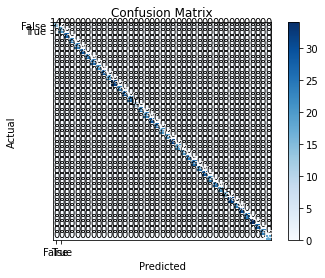

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()